# Предсказание температуры стали

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. 

Основные стадии технологического процесса:
* измерение температуры и химический анализ расплава
* нагрев
* добавление лигирующих добавок (проволоки (wire) и сыпучих материалов (bulk))
* продувка газом

### Цель

Построить модель, предсказывающую последнюю измеренную температуру по партии.

На тестовой выборке получить значение MAE не более 6,8.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## Загрузка данных и иследовательский анализ

In [166]:
RANDOM_STATE  = 220523 # заранее заданная константа

In [167]:
import pandas as pd
from sklearn.model_selection import (train_test_split, GridSearchCV, cross_val_score)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (mean_absolute_error, r2_score, make_scorer)
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor


**Загрузим данные**

In [168]:
try:
    data_arc_new = pd.read_csv('datasets/data_arc_new.csv')
    data_bulk_new = pd.read_csv('datasets/data_bulk_new.csv')
    data_bulk_time_new = pd.read_csv('datasets/data_bulk_time_new.csv')
    data_gas_new = pd.read_csv('datasets/data_gas_new.csv')
    data_temp_new = pd.read_csv('datasets/data_temp_new.csv')
    data_wire_new = pd.read_csv('datasets/data_wire_new.csv')
    data_wire_time_new = pd.read_csv('datasets/data_wire_time_new.csv')
except:
    data_arc_new = pd.read_csv('/datasets/data_arc_new.csv')
    data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')
    data_bulk_time_new = pd.read_csv('/datasets/data_bulk_time_new.csv')
    data_gas_new = pd.read_csv('/datasets/data_gas_new.csv')
    data_temp_new = pd.read_csv('/datasets/data_temp_new.csv')
    data_wire_new = pd.read_csv('/datasets/data_wire_new.csv')
    data_wire_time_new = pd.read_csv('/datasets/data_wire_time_new.csv')

**data_arc_new — данные об электродах**

In [169]:
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Названия столбцов записаны на разных языках. Также следует убрать пробелы.

In [170]:
data_arc_new.columns = ['key', "start_heating", 'end_heating', 'active_power', 'reactive_power']

In [171]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14876 non-null  int64  
 1   start_heating   14876 non-null  object 
 2   end_heating     14876 non-null  object 
 3   active_power    14876 non-null  float64
 4   reactive_power  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


В датасете data_arc_new представлены данные об электродах: начало и конец нагрева дугой, активная мощность, реактивная мощность. Имеется 14878 записей, пропусков нет. Для удобства дальнейшей работы следует преобразовать тип данных столбцов с временем.

In [172]:
data_arc_new[['start_heating' ,'end_heating']] = \
    data_arc_new[['start_heating' ,'end_heating']].astype("datetime64")
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   start_heating   14876 non-null  datetime64[ns]
 2   end_heating     14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [173]:
len(data_arc_new['key'].unique())

3214

Имеем данные о 3214 партиях.

In [174]:
data_arc_new['key'].value_counts()

2108    16
1689    15
1513    15
2567    14
46      13
        ..
977      1
247      1
2582     1
248      1
530      1
Name: key, Length: 3214, dtype: int64

Число итераций нагрева для партии лежит в пределах от 1 до 16,

In [175]:
data_arc_new.describe()

,key,active_power,reactive_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


<AxesSubplot:>

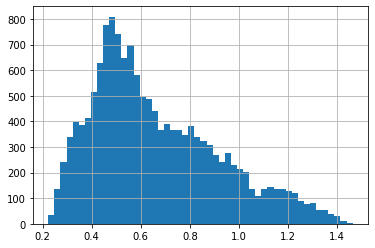

In [176]:
data_arc_new['active_power'].hist(bins=50)

<AxesSubplot:>

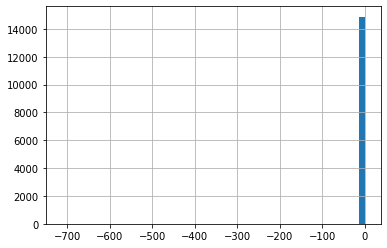

In [177]:
data_arc_new['reactive_power'].hist(bins=50)

In [178]:
data_arc_new[data_arc_new['reactive_power'] < 0]

,key,start_heating,end_heating,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Удалим одно явно выбивающееся значение

In [179]:
data_arc_new = data_arc_new[data_arc_new['reactive_power']>=0]

<AxesSubplot:>

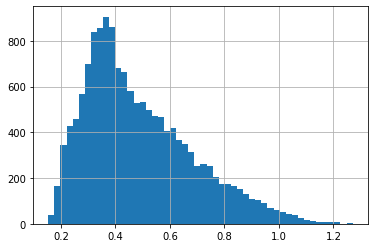

In [180]:
data_arc_new['reactive_power'].hist(bins=50)

**data_bulk_new — данные о подаче сыпучих материалов (объём)**

In [181]:
data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [182]:
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Имеются данные о 3129 партиях стали. 

Всего на заводе числится 15 различных сыпучих материалов. 

В одну партию могут добавляться несколько материалов. 

NaN в таблице можем заменить нулем (данный материал не использовался). 

В таблице есть материал, использованный только 1 раз, можем удалить этот столбец.

In [183]:
data_bulk_new.drop(['Bulk 8'] , axis=1, inplace=True)
data_bulk_new.fillna(0, inplace=True)
data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [184]:
(data_bulk_new % 1 == 0).all()

key        True
Bulk 1     True
Bulk 2     True
Bulk 3     True
Bulk 4     True
Bulk 5     True
Bulk 6     True
Bulk 7     True
Bulk 9     True
Bulk 10    True
Bulk 11    True
Bulk 12    True
Bulk 13    True
Bulk 14    True
Bulk 15    True
dtype: bool

Можем преобразовать тип данных float в int

In [185]:
data_bulk_new = data_bulk_new.astype(int)
data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0,0,0,43,0,0,0,0,0,0,206,0,150,154
1,2,0,0,0,73,0,0,0,0,0,0,206,0,149,154
2,3,0,0,0,34,0,0,0,0,0,0,205,0,152,153
3,4,0,0,0,81,0,0,0,0,0,0,207,0,153,154
4,5,0,0,0,78,0,0,0,0,0,0,203,0,151,152


**data_bulk_time_new — данные о подаче сыпучих материалов (время)**

In [186]:
data_bulk_time_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [187]:
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


В таблице представлены данные о времени подачи сыпучих материалов. 

По количеству значений в столбцах последние две таблицы совпадают: каждому добавленному объему соответствует время добавления.

Следует также удалить столбец Bulk 8.

Для удобства дальнейшей работы следует перевести столбцы во временной тип данных.

In [188]:
data_bulk_time_new.drop(['Bulk 8'], axis=1, inplace=True)

In [189]:
data_bulk_time_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [190]:
columns = data_bulk_time_new.columns[1:]
data_bulk_time_new[columns] = data_bulk_time_new[columns].astype('datetime64')
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 9   19 non-null     datetime64[ns]
 9   Bulk 10  176 non-null    datetime64[ns]
 10  Bulk 11  177 non-null    datetime64[ns]
 11  Bulk 12  2450 non-null   datetime64[ns]
 12  Bulk 13  18 non-null     datetime64[ns]
 13  Bulk 14  2806 non-null   datetime64[ns]
 14  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](14), int64(1)
memory usage: 366.8 KB


**data_gas_new — данные о продувке сплава газом**

In [191]:
data_gas_new.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Преобразуем название столбца 

In [192]:
data_gas_new.columns = ['key', 'gas']

In [193]:
data_gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [194]:
data_gas_new.describe()

,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


<AxesSubplot:>

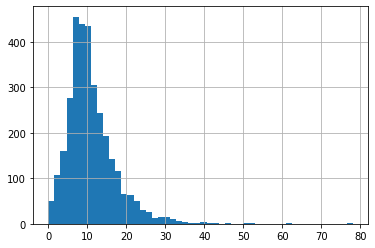

In [195]:
data_gas_new['gas'].hist(bins=50)

В данных имеются выбросы по объему прокачиваемого газ (больше 40). 

По условию задачи, выбросы можно убрать только на обучающей выборке, поэтому учтем этот момент после разделения данных на выборки.

**data_wire_new — данные о проволочных материалах (объём)**

In [196]:
data_wire_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [197]:
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


В таблице представлена информация о 3081 партии.

На заводе используют 9 проволочных лигирующих материалов.

Wire 5 использовался всего 1 раз. Удалим этот столбец.

В одну партию могут добавляться несколько материалов. 

NaN в таблице можем заменить нулем (данный материал не использовался). 



In [198]:
data_wire_new.drop(['Wire 5'], axis=1, inplace=True)
data_wire_new

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [199]:
data_wire_new = data_wire_new.fillna(0)
data_wire_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


**data_wire_time_new — данные о проволочных материалах (время)**

In [200]:
data_wire_time_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [201]:
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


В таблице представлены данные о времени подачи проволочных материалов. 

По количеству значений в столбцах последние две таблицы совпадают: каждому добавленному объему соответствует время добавления.

Следует также удалить столбец Wire 5.

Для удобства дальнейшей работы следует перевести столбцы во временной тип данных.

In [202]:
data_wire_time_new.drop(['Wire 5'], axis=1, inplace=True)

In [203]:
data_wire_time_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN


In [204]:
columns = data_wire_time_new.columns[1:]
data_wire_time_new[columns] = data_wire_time_new[columns].astype('datetime64')
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 6  73 non-null     datetime64[ns]
 6   Wire 7  11 non-null     datetime64[ns]
 7   Wire 8  19 non-null     datetime64[ns]
 8   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](8), int64(1)
memory usage: 216.8 KB


**data_temp_new — результаты измерения температуры**

In [205]:
data_temp_new.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


Изменим названия

In [206]:
data_temp_new.columns = ['key', 'temp_time', 'temperature']

In [207]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          18092 non-null  int64  
 1   temp_time    18092 non-null  object 
 2   temperature  14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [208]:
len(data_temp_new['key'].unique())

3216

In [209]:
data_temp_new['key'].value_counts()

2108    17
1513    16
1689    16
2567    15
322     14
        ..
556      2
1169     2
732      2
195      1
279      1
Name: key, Length: 3216, dtype: int64

Предположение. Число измерений для таблицы с температурами больше на 1, чем число итераций нагревания из первой таблицы для каждой партии. Это объясняется тем, что для кажой партии (кроме 195 и 279) помимо температуры после нагревания дугой имеется температура в начале технологического процесса.

195 и 279 партии следует удалить, поскольку для корректной работы модели необходимы начальная и конечная температуры.

Время замера следует преобразовать во временной тип данных.

In [210]:
data_temp_new = data_temp_new.query('key != 195 and key != 279')
data_temp_new['key'].value_counts()

2108    17
1513    16
1689    16
2567    15
322     14
        ..
248      2
1268     2
2179     2
1766     2
49       2
Name: key, Length: 3214, dtype: int64

In [211]:
data_temp_new['temp_time'] = data_temp_new['temp_time'].astype('datetime64')
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18090 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          18090 non-null  int64         
 1   temp_time    18090 non-null  datetime64[ns]
 2   temperature  14663 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 565.3 KB


In [212]:
(data_temp_new['temperature'] % 1 == 0)

0         True
1         True
2         True
3         True
4         True
         ...  
18087    False
18088    False
18089    False
18090    False
18091    False
Name: temperature, Length: 18090, dtype: bool

In [213]:
data_temp_new[data_temp_new['temperature'] % 1 != 0]

,key,temp_time,temperature
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN
13932,2501,2019-08-10 14:49:15,NaN
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


После обработки пропусков столбец temperature можно преобразовать в тип int

In [214]:
data_temp_new.describe()

,key,temperature
count,18090.000000,14663.000000
mean,1616.613488,1590.722431
std,934.580382,20.395420
min,1.000000,1191.000000
25%,808.000000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


<AxesSubplot:>

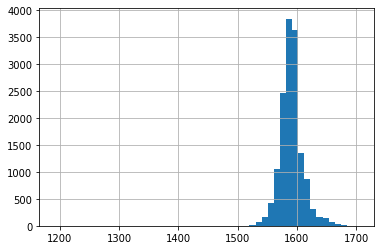

In [215]:
data_temp_new['temperature'].hist(bins=50)

### Вывод

Данные разбросаны по нескольким таблицам. В некоторых таблицах имеются пропуски, часть из которых удалось заполнить. Следует обратить особое внимание на пропуски в столбце с температурами. Для обучения моделей будут использоваться только первое и последнее измерения температуры, поэтому пропуски в промежуточных измерениях не так важны. Также в дальнейшем необходимо в обучающей выборке удалить выбросы согласно критериям заказчика. Часть предобработки была выполнена в процессе выгрузки и изучения данных. Так были изменены названия столбцов, убраны явные ошибочные значения, изменены типы данных.

# План работы

1. Исследовательский анализ данных. Загрузить и изучить данные;
2. Предобработка данных и объединение таблиц. Разделить данные, удалить выбросы в обучающей выборке согласно критериям заказчика, явно выделить целевой признак, объединить таблицы;
3. Построить модель. Рассмотреть несколько моделей, подобрать гиперпараметры, протестировать лучшую модель.
4. Подготовить отчет.

# Вопросы

* Лигирующие компоненты в сплав могли и не добавляться, поэтому использовать INNER при объединении с этими таблицами не стоит. При отсутствии данных для партии заменяем их нулями. Так?

# Предобработка данных

### Добавление новых признаков

Вернемся к таблице с данными о нагревании дугой

In [216]:
data_arc_new.head()

,key,start_heating,end_heating,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Можем добавить новые признаки, такие как полная мощность, работа, коэффициент мощности.

Полная мощность рассчитывается по формуле:


$$S=\sqrt{P^2+Q^2}$$


Где P – активная мощность, Q – реактивная мощность.

Работа расчитывается по формуле:

$$A = S \times \Delta t$$

Где $\Delta t$ – интервал нагревания.

Коэффициент мощности расчитывается по формуле:

$$cos  \phi = \dfrac{P}{S}$$

In [217]:
data_arc_new.columns = ['key', 't1', 't2', 'P', 'Q']
data_arc_new.head()

,key,t1,t2,P,Q
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [218]:
data_arc_new['S'] = (data_arc_new['P']**2 + data_arc_new['Q']**2)**0.5
data_arc_new['delta_t'] = data_arc_new['t2'] - data_arc_new['t1'] 
data_arc_new.head()

,key,t1,t2,P,Q,S,delta_t
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,0 days 00:03:48
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,0 days 00:03:05
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,0 days 00:02:52
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,0 days 00:06:05
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,0 days 00:02:28


In [219]:
# вспомогательная функция для получения продолжительности нагрева в секундах
def get_seconds(x):
    return x.seconds

In [220]:
data_arc_new['delta_t'] = data_arc_new['delta_t'].apply(get_seconds)
data_arc_new['A'] = data_arc_new['S'] * data_arc_new['delta_t']
data_arc_new['cos'] = data_arc_new['P'] / data_arc_new['S']
data_arc_new.head()

,key,t1,t2,P,Q,S,delta_t,A,cos
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,228,84.616003,0.822181
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,185,166.928978,0.848545
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,172,124.276277,0.803161
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,365,234.630603,0.806591
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,148,159.830252,0.802950


Сами по себе время начала и конца нагрева бесполезны, можем оставить только продолжительность нагрева.

In [221]:
data_arc_new = data_arc_new.drop(['t1', 't2'], axis=1)
data_arc_new.head()

,key,P,Q,S,delta_t,A,cos
0,1,0.305130,0.211253,0.371123,228,84.616003,0.822181
1,1,0.765658,0.477438,0.902319,185,166.928978,0.848545
2,1,0.580313,0.430460,0.722536,172,124.276277,0.803161
3,1,0.518496,0.379979,0.642824,365,234.630603,0.806591
4,1,0.867133,0.643691,1.079934,148,159.830252,0.802950


Согласно требованиям заказчика, удаляем ключи с одним замером.

In [222]:
data_arc_new.shape[0]

14875

In [223]:
t = data_arc_new.groupby(by='key')['key'].count() <= 1
keys_to_delete = list(t[t == 1].index)
keys_to_delete[:10]

[49, 112, 246, 247, 248, 269, 343, 530, 556, 614]

In [224]:
data_arc_new = data_arc_new.query('key not in @keys_to_delete')

In [225]:
data_arc_new.shape[0]

14836

Ключи с отрицательными значениями реактивной мощности уже удалены

In [226]:
data_arc_new[data_arc_new['Q'] < 0].shape[0]

0

Выполним агрегацию, чтобы одному ключу соответсвовало одно значение каждого признака.

In [227]:
data_arc_new = data_arc_new.groupby(by='key').mean()
data_arc_new.head()

,P,Q,S,delta_t,A,cos
key,,,,,,
1,0.607346,0.428564,0.743747,219.60,154.056423,0.816686
2,0.534852,0.363339,0.647087,202.75,120.440001,0.825276
3,0.812728,0.587491,1.003845,131.00,144.567534,0.809724
4,0.676622,0.514248,0.850010,185.25,170.863899,0.793923
5,0.563238,0.421998,0.704245,217.25,128.042484,0.796818


### Выделение целевого признака

Для обучения будем использовать начальную температуру, конечная же температура будет целевым признаком. Остальные значения должны быть отброшены во избежание утечки данных. При этом те ключи, у которых неизвестна начальная или конечная температура, также должны быть отброшены.

In [228]:
data_temp_new.head()

,key,temp_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


Сгруппируем данные по партиям, получим началные и конечные измерения для каждой партии

In [229]:
keys = data_temp_new['key'].unique()
data_temp_t = pd.DataFrame()
for key in keys:
    sorted = data_temp_new[data_temp_new['key']==key].sort_values(by='temp_time')
    temp1 = sorted.iloc[0]['temperature']
    temp2 = sorted.iloc[-1]['temperature']
    t1 = sorted.iloc[0]['temp_time']
    t2 = sorted.iloc[-1]['temp_time']
    data_temp_t = data_temp_t.append({'key': key, 'start': t1, 'temperature_1': temp1,
                        'end': t2, 'temperature_2': temp2}, ignore_index=True)

In [230]:
data_temp_t = data_temp_t[['key', 'start', 'temperature_1', 'end', 'temperature_2']]
data_temp_t

,key,start,temperature_1,end,temperature_2
0,1.0,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0
1,2.0,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0
2,3.0,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0
3,4.0,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0
4,5.0,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0
...,...,...,...,...,...
3209,3237.0,2019-09-06 11:31:15,1569.0,2019-09-06 11:55:45,NaN
3210,3238.0,2019-09-06 12:16:15,1584.0,2019-09-06 12:34:37,NaN
3211,3239.0,2019-09-06 14:16:50,1598.0,2019-09-06 15:09:55,NaN
3212,3240.0,2019-09-06 15:25:21,1617.0,2019-09-06 16:35:26,NaN


In [231]:
data_temp_new = data_temp_t
data_temp_new.columns = ['key', 'start', 'temperature_1', 'end', 'temperature_2']
data_temp_new = data_temp_new.reset_index()
data_temp_new = data_temp_new.drop(['index'], axis=1)
data_temp_new.head()

,key,start,temperature_1,end,temperature_2
0,1.0,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0
1,2.0,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0
2,3.0,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0
3,4.0,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0
4,5.0,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0


In [232]:
data_temp_new.tail()

,key,start,temperature_1,end,temperature_2
3209,3237.0,2019-09-06 11:31:15,1569.0,2019-09-06 11:55:45,NaN
3210,3238.0,2019-09-06 12:16:15,1584.0,2019-09-06 12:34:37,NaN
3211,3239.0,2019-09-06 14:16:50,1598.0,2019-09-06 15:09:55,NaN
3212,3240.0,2019-09-06 15:25:21,1617.0,2019-09-06 16:35:26,NaN
3213,3241.0,2019-09-06 16:48:55,1586.0,2019-09-06 17:30:05,NaN


Необходимо будет удалить ключи с пропущенными значениями 

Вместо столбцов с временем начала и конца процесса добавим столбец с продолжительностью процесса.

In [233]:
data_temp_new['process_time'] = data_temp_new['end'] - data_temp_new['start']
data_temp_new['process_time'] = data_temp_new['process_time'].apply(get_seconds)
data_temp_new = data_temp_new.drop(columns=['start', 'end'], axis=1)
data_temp_new.head()

,key,temperature_1,temperature_2,process_time
0,1.0,1571.0,1613.0,1714
1,2.0,1581.0,1602.0,1265
2,3.0,1596.0,1599.0,1753
3,4.0,1601.0,1625.0,1220
4,5.0,1576.0,1602.0,1536


Согласно требованию заказчика ключи с температурой ниже 1500 грудусов необходимо удалить

In [234]:
data_temp_new.tail()

,key,temperature_1,temperature_2,process_time
3209,3237.0,1569.0,NaN,1470
3210,3238.0,1584.0,NaN,1102
3211,3239.0,1598.0,NaN,3185
3212,3240.0,1617.0,NaN,4205
3213,3241.0,1586.0,NaN,2470


In [235]:
data_temp_new.query('temperature_1 < 1500 | temperature_2 < 1500')

,key,temperature_1,temperature_2,process_time
853,867.0,1191.0,1599.0,2684
1199,1214.0,1208.0,1591.0,2573
1602,1619.0,1218.0,1590.0,558
2034,2052.0,1227.0,1592.0,2268
2536,2561.0,1204.0,NaN,1936


In [236]:
data_temp_new.shape[0]

3214

In [237]:
data_temp_new = data_temp_new.query('temperature_1 > 1500 & temperature_2 > 1500')
data_temp_new.shape[0]

2471

Также последняя операция удаляет пропущенные значение (NaN)

In [238]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 0 to 2474
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            2471 non-null   float64
 1   temperature_1  2471 non-null   float64
 2   temperature_2  2471 non-null   float64
 3   process_time   2471 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 96.5 KB


Преобразуем тип данных для столбов с температурой

In [239]:
data_temp_new[['temperature_1', 'temperature_2']] = data_temp_new[['temperature_1', 'temperature_2']].astype('int64')
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 0 to 2474
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            2471 non-null   float64
 1   temperature_1  2471 non-null   int64  
 2   temperature_2  2471 non-null   int64  
 3   process_time   2471 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 96.5 KB


### Объединение таблиц

Объединим поулученные таблицы в общий датафрейм. 

Будем использовать метод INNER, поскольку важно, что бы ключи присутствовали во всех датафреймах. 

Время добавления сыпучих и проволочных материалов пока учитывать не будем. При необходимости (недостаточная точность модели) добавим новый признак - время, через которое были добавлены материалы с момента начала технологического процесса.

In [240]:
df = data_arc_new.merge(data_gas_new, on='key', how='inner')
df = df.merge(data_temp_new, on='key', how='inner')
df = df.merge(data_bulk_new, on='key', how='inner')
df = df.merge(data_wire_new, on='key', how='inner')
df.head()

,key,P,Q,S,delta_t,A,cos,gas,temperature_1,temperature_2,...,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1,0.607346,0.428564,0.743747,219.60,154.056423,0.816686,29.749986,1571,1613,...,150,154,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.534852,0.363339,0.647087,202.75,120.440001,0.825276,12.555561,1581,1602,...,149,154,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.812728,0.587491,1.003845,131.00,144.567534,0.809724,28.554793,1596,1599,...,152,153,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.676622,0.514248,0.850010,185.25,170.863899,0.793923,18.841219,1601,1625,...,153,154,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.563238,0.421998,0.704245,217.25,128.042484,0.796818,5.413692,1576,1602,...,151,152,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


In [241]:
df.shape[0]

2300

Столбец `key` больше не нужен

In [242]:
df = df.drop('key', axis=1)
df.head()

,P,Q,S,delta_t,A,cos,gas,temperature_1,temperature_2,process_time,...,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,0.607346,0.428564,0.743747,219.60,154.056423,0.816686,29.749986,1571,1613,1714,...,150,154,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.534852,0.363339,0.647087,202.75,120.440001,0.825276,12.555561,1581,1602,1265,...,149,154,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.812728,0.587491,1.003845,131.00,144.567534,0.809724,28.554793,1596,1599,1753,...,152,153,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.676622,0.514248,0.850010,185.25,170.863899,0.793923,18.841219,1601,1625,1220,...,153,154,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.563238,0.421998,0.704245,217.25,128.042484,0.796818,5.413692,1576,1602,1536,...,151,152,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


In [243]:
df.tail()

,P,Q,S,delta_t,A,cos,gas,temperature_1,temperature_2,process_time,...,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
2295,0.792033,0.552734,0.967180,180.750000,173.544332,0.812727,7.125735,1570,1591,1380,...,129,223,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2296,0.695820,0.478672,0.845053,156.666667,135.969756,0.819606,9.412616,1554,1591,1705,...,129,226,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2297,1.201746,0.817364,1.453639,189.666667,274.340173,0.827613,6.271699,1571,1589,962,...,124,226,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0
2298,0.640462,0.447964,0.781983,150.000000,116.362148,0.819245,14.953657,1591,1594,1520,...,129,207,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2299,0.434271,0.324209,0.542313,220.750000,133.096546,0.800782,11.336151,1569,1603,1537,...,126,227,110.160958,50.00528,0.0,0.0,0.0,0.0,0.0,0.0


Построим матрицу корреляций

In [244]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,P,Q,S,delta_t,A,cos,gas,temperature_1,temperature_2,process_time,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
P,1.000000,0.965847,0.995453,0.030369,0.591057,0.008079,0.034746,-0.005145,0.036013,0.023181,0.022229,0.002551,0.026065,0.022394,0.004059,-0.003489,0.008882,-0.011280,-0.008192,0.021048,0.034226,-0.014292,0.017559,0.034276,0.038137,-0.011826,0.019323,-0.005676,0.010467,-0.003916,-0.005502,0.000241
Q,0.965847,1.000000,0.986123,0.019941,0.578100,-0.232930,0.035227,-0.000698,0.028123,0.022793,0.017755,-0.000942,0.021264,0.022526,-0.000465,-0.003038,0.008712,-0.018262,-0.011814,0.020105,0.037745,-0.013650,0.012948,0.032106,0.043708,-0.013285,0.020624,-0.005245,0.005981,0.003420,-0.013409,0.010172
S,0.995453,0.986123,1.000000,0.026811,0.591042,-0.080387,0.035205,-0.003545,0.033344,0.023297,0.020784,0.001333,0.024576,0.022601,0.002465,-0.003492,0.008892,-0.013922,-0.009642,0.020805,0.035751,-0.014174,0.016008,0.033658,0.040508,-0.012456,0.019911,-0.005549,0.008951,-0.001232,-0.008437,0.004066
delta_t,0.030369,0.019941,0.026811,1.000000,0.763714,0.045589,0.096650,-0.435217,0.195641,0.059426,0.050829,-0.043042,0.017705,-0.037968,-0.045379,0.046072,-0.048883,-0.028688,-0.030042,0.037746,0.366260,0.008351,0.324850,0.274452,-0.100579,-0.015483,-0.004549,-0.045453,0.012701,-0.032114,-0.027628,0.011837
A,0.591057,0.578100,0.591042,0.763714,1.000000,-0.013539,0.083503,-0.342789,0.162539,0.050706,0.047757,-0.032759,0.030718,-0.024365,-0.027252,0.039418,-0.032174,-0.025484,-0.029727,0.030075,0.292640,0.008946,0.247045,0.227113,-0.060789,-0.010620,0.009342,-0.037455,0.022347,-0.027070,-0.021162,0.009956
cos,0.008079,-0.232930,-0.080387,0.045589,-0.013539,1.000000,-0.002249,-0.026381,0.018613,-0.005018,0.012074,0.005189,0.021166,-0.013967,0.017573,0.006860,-0.001525,0.022136,0.008133,0.017623,-0.024098,-0.004290,0.032935,0.009396,-0.032851,0.027238,-0.009010,-0.002967,0.010188,-0.027500,0.026805,-0.030570
gas,0.034746,0.035227,0.035205,0.096650,0.083503,-0.002249,1.000000,0.043667,0.054959,0.447708,0.233209,0.217967,0.056155,0.017624,0.086394,0.140141,0.198835,0.116610,-0.010566,0.043936,0.211466,0.048697,0.265960,0.035365,0.116720,0.105119,0.102981,0.145659,0.107740,0.079119,0.118115,0.011071
temperature_1,-0.005145,-0.000698,-0.003545,-0.435217,-0.342789,-0.026381,0.043667,1.000000,0.306872,0.208406,0.083373,0.144072,-0.110688,0.166347,0.081060,-0.127694,0.089570,-0.032913,0.039129,-0.110285,-0.065865,0.021375,-0.164272,-0.047754,0.263269,-0.103792,-0.002044,0.077778,0.022332,0.053791,-0.029318,-0.004857
temperature_2,0.036013,0.028123,0.033344,0.195641,0.162539,0.018613,0.054959,0.306872,1.000000,0.100605,-0.077091,-0.083318,-0.039652,0.186749,-0.029124,-0.181747,-0.108237,-0.016534,0.060498,-0.113304,0.265119,-0.011367,0.114136,0.263905,0.316114,-0.207725,-0.048408,-0.160983,-0.085105,-0.138221,-0.011190,-0.028295
process_time,0.023181,0.022793,0.023297,0.059426,0.050706,-0.005018,0.447708,0.208406,0.100605,1.000000,0.147366,0.270147,0.026361,0.002861,0.105239,0.156078,0.240433,-0.006507,-0.007651,0.035355,0.219953,0.247065,0.183897,0.109026,0.162472,0.058175,0.069677,0.255888,0.146010,0.158058,-0.002036,0.005016


Наблюдается сильная корреляция признаков P, Q, S, также сильна корреляция между A и $\Delta t$.  Наблюдается очень сильная прямая зависимость между Wire 8 и Bulk 9, видимо, они добавляются практически в равных объемах. 

Удалим высоко коррелирующие признаки, оставив только по одному в каждой паре.

In [245]:
df = df.drop(['P', 'Q', 'Wire 8'], axis=1)

In [246]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,S,delta_t,A,cos,gas,temperature_1,temperature_2,process_time,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 9
S,1.000000,0.026811,0.591042,-0.080387,0.035205,-0.003545,0.033344,0.023297,0.020784,0.001333,0.024576,0.022601,0.002465,-0.003492,0.008892,-0.013922,-0.009642,0.020805,0.035751,-0.014174,0.016008,0.033658,0.040508,-0.012456,0.019911,-0.005549,0.008951,-0.001232,0.004066
delta_t,0.026811,1.000000,0.763714,0.045589,0.096650,-0.435217,0.195641,0.059426,0.050829,-0.043042,0.017705,-0.037968,-0.045379,0.046072,-0.048883,-0.028688,-0.030042,0.037746,0.366260,0.008351,0.324850,0.274452,-0.100579,-0.015483,-0.004549,-0.045453,0.012701,-0.032114,0.011837
A,0.591042,0.763714,1.000000,-0.013539,0.083503,-0.342789,0.162539,0.050706,0.047757,-0.032759,0.030718,-0.024365,-0.027252,0.039418,-0.032174,-0.025484,-0.029727,0.030075,0.292640,0.008946,0.247045,0.227113,-0.060789,-0.010620,0.009342,-0.037455,0.022347,-0.027070,0.009956
cos,-0.080387,0.045589,-0.013539,1.000000,-0.002249,-0.026381,0.018613,-0.005018,0.012074,0.005189,0.021166,-0.013967,0.017573,0.006860,-0.001525,0.022136,0.008133,0.017623,-0.024098,-0.004290,0.032935,0.009396,-0.032851,0.027238,-0.009010,-0.002967,0.010188,-0.027500,-0.030570
gas,0.035205,0.096650,0.083503,-0.002249,1.000000,0.043667,0.054959,0.447708,0.233209,0.217967,0.056155,0.017624,0.086394,0.140141,0.198835,0.116610,-0.010566,0.043936,0.211466,0.048697,0.265960,0.035365,0.116720,0.105119,0.102981,0.145659,0.107740,0.079119,0.011071
temperature_1,-0.003545,-0.435217,-0.342789,-0.026381,0.043667,1.000000,0.306872,0.208406,0.083373,0.144072,-0.110688,0.166347,0.081060,-0.127694,0.089570,-0.032913,0.039129,-0.110285,-0.065865,0.021375,-0.164272,-0.047754,0.263269,-0.103792,-0.002044,0.077778,0.022332,0.053791,-0.004857
temperature_2,0.033344,0.195641,0.162539,0.018613,0.054959,0.306872,1.000000,0.100605,-0.077091,-0.083318,-0.039652,0.186749,-0.029124,-0.181747,-0.108237,-0.016534,0.060498,-0.113304,0.265119,-0.011367,0.114136,0.263905,0.316114,-0.207725,-0.048408,-0.160983,-0.085105,-0.138221,-0.028295
process_time,0.023297,0.059426,0.050706,-0.005018,0.447708,0.208406,0.100605,1.000000,0.147366,0.270147,0.026361,0.002861,0.105239,0.156078,0.240433,-0.006507,-0.007651,0.035355,0.219953,0.247065,0.183897,0.109026,0.162472,0.058175,0.069677,0.255888,0.146010,0.158058,0.005016
Bulk 1,0.020784,0.050829,0.047757,0.012074,0.233209,0.083373,-0.077091,0.147366,1.000000,0.224557,-0.012607,0.041399,0.060053,-0.003884,0.237106,-0.020015,-0.024048,-0.037923,0.325111,-0.010546,0.207123,-0.004616,0.013366,-0.008558,0.019879,0.146151,0.148252,0.083376,0.012501
Bulk 2,0.001333,-0.043042,-0.032759,0.005189,0.217967,0.144072,-0.083318,0.270147,0.224557,1.000000,-0.047311,0.040767,0.360236,-0.030165,0.679336,-0.005401,-0.018249,0.001533,-0.100807,-0.005663,-0.144637,-0.107848,-0.171020,-0.039164,0.223120,0.699325,0.558847,0.431726,-0.006747


### Разделение данных

In [247]:
train, test = train_test_split(df, test_size=0.25, random_state=RANDOM_STATE)

### Выбросы

По требованию заказчика для обучения должно остаться миниму 1700 партий, это необходимо учитывать при обработке выбросов.

In [248]:
train.shape[0]

1725

In [249]:
train.head(3)

,S,delta_t,A,cos,gas,temperature_1,temperature_2,process_time,Bulk 1,Bulk 2,...,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 9
362,0.901711,203.25,205.482172,0.807060,7.419336,1570,1591,1455,0,0,...,0,103,203,20.124001,29.13456,0.0,0.0,0.0,0.0,0.0
1705,0.900800,173.00,145.682550,0.814706,5.551631,1600,1593,2084,0,0,...,0,101,203,60.465601,15.08000,0.0,0.0,0.0,0.0,0.0
1664,0.884661,131.50,120.500391,0.805257,1.870435,1658,1633,2953,0,0,...,0,98,104,147.139206,0.00000,0.0,0.0,0.0,0.0,0.0


[array([0.71238617, 0.3996407 ]), array([0.92110578, 1.23081423])]

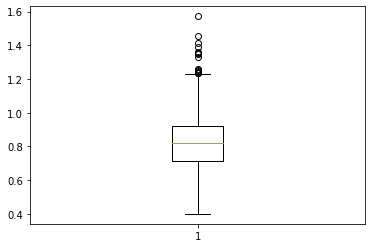

In [250]:
image = plt.boxplot(train['S'])
[item.get_ydata() for item in image['whiskers']]

In [251]:
train = train.query('S <= 1.30')
train.shape[0]

1717

[array([142.75,  63.5 ]), array([199.2, 282.5])]

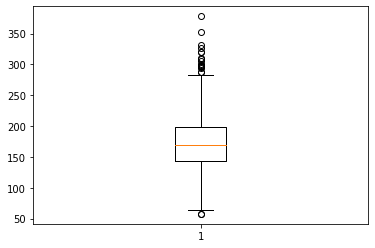

In [252]:
image = plt.boxplot(train['delta_t'])
[item.get_ydata() for item in image['whiskers']]

In [253]:
train = train.query('delta_t <= 300')
train.shape[0]

1708

[array([7.32726408, 0.0166956 ]), array([14.21848652, 24.2733093 ])]

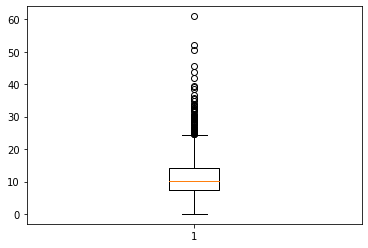

In [254]:
image = plt.boxplot(train['gas'])
[item.get_ydata() for item in image['whiskers']]

In [255]:
train = train.query('gas <= 40')
train.shape[0]

1702

Разделим данные на features и target

In [256]:
features_train = train.drop('temperature_2', axis=1)
features_test = test.drop('temperature_2', axis=1)

In [257]:
target_train = train['temperature_2']
target_test = test['temperature_2']

### Масштабирование данных

In [258]:
scaler = StandardScaler()

In [259]:
features_train[:] = scaler.fit_transform(features_train[:])
features_train.head()

,S,delta_t,A,cos,gas,temperature_1,process_time,Bulk 1,Bulk 2,Bulk 3,...,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 9
362,0.505843,0.748982,1.350838,0.093050,-0.650092,-0.732741,-0.637400,-0.293754,-0.072781,-0.629394,...,-0.061166,-0.663613,0.946894,-1.920427,0.361703,-0.114606,-0.067661,-0.111936,-0.033232,-0.095325
1705,0.499920,0.024690,0.074267,0.651063,-0.961543,0.552690,-0.172185,-0.293754,-0.072781,-0.629394,...,-0.061166,-0.689147,0.946894,-0.984168,-0.069409,-0.114606,-0.067661,-0.111936,-0.033232,-0.095325
1664,0.394993,-0.968965,-0.463309,-0.038543,-1.575405,3.037857,0.470536,-0.293754,-0.072781,-0.629394,...,-0.061166,-0.727448,-0.234379,1.027377,-0.531976,-0.114606,-0.067661,-0.111936,-0.033232,-0.095325
329,-0.333522,0.076568,-0.196740,-0.843750,-0.014713,-0.004330,-0.064941,-0.293754,-0.072781,-0.629394,...,-0.061166,1.123784,0.362224,0.426737,-0.531976,-0.114606,-0.067661,-0.111936,-0.033232,-0.095325
87,-0.970950,0.463655,-0.262308,0.477298,0.074946,-0.090025,-0.332680,-0.293754,-0.072781,0.730388,...,-0.061166,-1.978626,-1.475312,0.285755,-0.531976,-0.114606,-0.067661,-0.111936,-0.033232,-0.095325


In [260]:
features_test[:] = scaler.transform(features_test[:])
features_test.head()

,S,delta_t,A,cos,gas,temperature_1,process_time,Bulk 1,Bulk 2,Bulk 3,...,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 9
890,0.534740,0.048634,0.299916,-0.618029,-0.444509,1.366797,-0.798635,-0.293754,-0.072781,-0.629394,...,-0.061166,-0.446572,0.982691,-0.736527,-0.531976,-0.114606,-0.067661,-0.111936,-0.033232,-0.095325
473,0.102692,-0.118971,0.214647,-1.111733,-0.626548,-1.075523,-0.538292,-0.293754,-0.072781,-0.376101,...,-0.061166,1.264222,-1.475312,-0.662669,2.446953,-0.114606,-0.067661,-0.111936,-0.033232,-0.095325
218,0.073697,2.185592,1.438078,0.328450,2.578194,2.780771,1.437946,1.956859,-0.072781,0.717057,...,-0.061166,0.702469,0.946894,1.447498,1.526924,-0.114606,-0.067661,-0.111936,-0.033232,-0.095325
2294,-1.313052,0.272107,-0.725077,-0.060691,-1.223113,-0.090025,-1.044185,-0.293754,-0.072781,-0.629394,...,-0.061166,-0.459339,0.374156,-0.645870,-0.531976,-0.114606,-0.067661,-0.111936,-0.033232,-0.095325
1115,0.066277,1.108134,0.599412,0.810677,-0.677827,-0.946980,-0.408860,-0.293754,-0.072781,-0.629394,...,-0.061166,-0.025257,-1.475312,0.049844,-0.531976,-0.114606,-0.067661,-0.111936,-0.033232,-0.095325


In [261]:
target_train

362     1591
1705    1593
1664    1633
329     1598
87      1592
        ... 
1544    1575
1489    1617
338     1603
440     1593
1253    1556
Name: temperature_2, Length: 1702, dtype: int64

В ходе предобработки, согласно критериям заказчика, были удалены выбросы. Пропущенные значения в таблицах с объемами добавляемого материала были заполнены нулями (материал не использовался). Партии с пропусками в начальной или конечной температурах были отброшены. Также были добавлены новые признаки, основанные на физических формулах.


Можем приступать к обучению моделей.

## Модели

**Модель линейной регрессии**

In [262]:
mae = make_scorer(mean_absolute_error, greater_is_better=False)

In [263]:
linear_model = LinearRegression()

MAE

In [264]:
cross_val_score(linear_model, features_train, 
                target_train, cv=5, 
                scoring='neg_mean_absolute_error').mean()

-6.839870416084712

R2_score

In [265]:
linear_model.fit(features_train, target_train)
linear_predictions = linear_model.predict(features_train)
r2_score(target_train, linear_predictions)

0.396787905906677

**Модель регрессии случайного леса**

In [266]:
forest_model = RandomForestRegressor()

Создаем GridSearchCV объект

In [267]:
GS_forest = GridSearchCV(estimator = forest_model,
                  param_grid = {'n_estimators':[x for x in range(50, 300, 50)],
                                'max_depth': [x for x in range(3, 8)],
                                'random_state':[RANDOM_STATE]},
                  scoring = 'neg_mean_absolute_error',
                  cv=5
                  )

In [268]:
GS_forest.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'n_estimators': [50, 100, 150, 200, 250],
                         'random_state': [220523]},
             scoring='neg_mean_absolute_error')

MAE

In [269]:
GS_forest.best_score_

-6.841072206147716

r2_score

In [270]:
best_forest = GS_forest.best_estimator_

In [271]:
forest_predictions = best_forest.predict(features_train)
r2_score(target_train, forest_predictions)


0.6331726724005338

**Градиентный бустинг с момощью CatBoost**

In [272]:
cat_booster = CatBoostRegressor()

In [273]:
GS_cat = GridSearchCV(estimator = cat_booster,
                  param_grid = {'learning_rate':[0.05, 0.1],
                                'n_estimators':[x for x in range(80, 121, 20)],
                                'random_state':[RANDOM_STATE]},
                  scoring = 'neg_mean_absolute_error',
                  cv=5)

In [274]:
GS_cat.fit(features_train, target_train)

0:	learn: 11.0846888	total: 56.5ms	remaining: 4.46s
1:	learn: 10.9435770	total: 62ms	remaining: 2.42s
2:	learn: 10.8169281	total: 65.7ms	remaining: 1.69s
3:	learn: 10.7190826	total: 70.7ms	remaining: 1.34s
4:	learn: 10.6138112	total: 75.6ms	remaining: 1.13s
5:	learn: 10.5276683	total: 78.9ms	remaining: 973ms
6:	learn: 10.4448525	total: 82.4ms	remaining: 859ms
7:	learn: 10.3480498	total: 85.9ms	remaining: 773ms
8:	learn: 10.2722316	total: 89.1ms	remaining: 703ms
9:	learn: 10.1866626	total: 92.5ms	remaining: 647ms
10:	learn: 10.1029773	total: 95.6ms	remaining: 600ms
11:	learn: 10.0222065	total: 100ms	remaining: 567ms
12:	learn: 9.9554871	total: 106ms	remaining: 548ms
13:	learn: 9.8887138	total: 111ms	remaining: 524ms
14:	learn: 9.8303549	total: 116ms	remaining: 503ms
15:	learn: 9.7603178	total: 122ms	remaining: 487ms
16:	learn: 9.7083118	total: 127ms	remaining: 471ms
17:	learn: 9.6525103	total: 132ms	remaining: 455ms
18:	learn: 9.6049104	total: 137ms	remaining: 441ms
19:	learn: 9.5565403

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f874d3123a0>,
             param_grid={'learning_rate': [0.05, 0.1],
                         'n_estimators': [80, 100, 120],
                         'random_state': [220523]},
             scoring='neg_mean_absolute_error')

MAE

In [275]:
GS_cat.best_score_

-6.732739076349462

In [276]:
cat_best = GS_cat.best_estimator_

r2_score

In [278]:
cat_predictions = cat_best.predict(features_train)
r2_score(target_train, cat_predictions)

0.6537187994276163

## Тестирование

Наилучший результат показала модель градиентного бустинга. Протестируем ее.

In [292]:
cat_predictions = cat_best.predict(features_test)

MAE

In [293]:
mean_absolute_error(target_test, cat_predictions)

6.137940522092953

r2_score

In [294]:
r2_score(target_test, cat_predictions)

0.4261097658995212

In [295]:
cat_best.get_params()

{'learning_rate': 0.1,
 'loss_function': 'RMSE',
 'n_estimators': 120,
 'random_state': 220523}

**Сравним модель с константной**

In [296]:
dummy_regr = DummyRegressor(strategy="mean")

In [297]:
dummy_regr.fit(features_train, target_train)

DummyRegressor()

In [298]:
dummy_predictions = dummy_regr.predict(features_test)

MAE

In [299]:
mean_absolute_error(target_test, dummy_predictions)

8.004423440453676

r2_score

In [300]:
r2_score(target_test, dummy_predictions)

-9.812491481131502e-06

Модель прошла проверку на адекватность

Для константной модели, дающей в качестве предсказания среднее значение, r2_score предсказуемо равен 0. Для CatBoost на обучающей выборке это значение составило 0,65, на тестовой - 0,43. Что характеризует, насколько модель лучше предсказывает значения, чем это делает константная модель, использующая среднее арифметическое.

## Исследование важности признаков

In [301]:
feature_names = features_train.columns

In [302]:
importances  = cat_best.feature_importances_
importances

array([1.83255796e+00, 1.12198275e+01, 4.62311161e+00, 2.31315130e+00,
       3.79217923e+00, 2.24318842e+01, 7.80903120e+00, 3.54373240e+00,
       4.26670083e-01, 1.21508145e+00, 2.20587753e+00, 1.87532742e-02,
       3.75231050e+00, 8.74967952e-01, 9.62138983e-03, 5.53935402e-01,
       3.99234149e-01, 8.12709082e+00, 2.13421034e-01, 5.15360320e+00,
       5.00472329e+00, 8.81819529e+00, 4.43751173e+00, 7.14749786e-02,
       4.39320613e-01, 6.46450249e-01, 6.16827894e-02, 4.59879717e-03])

In [303]:
importances = pd.Series(importances, index=feature_names)

Text(0.5, 1.0, 'Значимость признаков для CatBoostRegression')

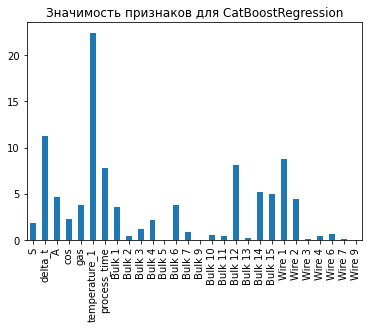

In [304]:
fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title("Значимость признаков для CatBoostRegression")

Получаем, что на работу лучшей модели (CatBoostRegression) наибольшее влияние оказывают исходная температура и средняя продолжительность итераций нагревания. В то же время влияние добавления многих проволочных и сыпучих материалов практически не учитывается, поэтому в дальнейшем их можно исключить из обучения.

# Вывод

Целью проекта являлось создание модели, предсказывающей температуру стали в конце технологического процесса.


Для работы были предоставлены данные об итерациях нагревания (время и затраченная мощность), подаче сыпучих и проволочных материалов (время и объем), объеме продуваемого газа, измерении температуры.

В ходе предобработки, согласно критериям заказчика, были удалены выбросы. Пропущенные значения в таблицах с объемами добавляемого материала были заполнены нулями (материал не использовался). Партии с пропусками в начальной или конечной температурах были отброшены. Также были добавлены новые признаки, основанные на физических формулах.


После предобработки все данные были объединены по номеру партии. Из кажой пары высоко коррелирующих признаков был оставлен только один.


Данные были разделены на обучающую и тестовую выборки. Выбивающиеся значения, согласно требованиям заказчика, были удалены только для обучающей выборки. Было выполнено масштабирование данных.


Были опробованы три модели:
- Модель линейной регрессии;
- Модель регрессии случайного леса;
- Модель градиентного бустинга CatBoost.


Для последних двух моделей были подобраны гиперпараметры. Согласно требованиям заказчика, модели обучались на кросс-валидации. 


Наилучшего значения заданной метрики MAE достигла модель градиентного бустинга CatBoostRegressor с гиперпараметрами:
- 'learning_rate': 0.1;
- 'loss_function': 'RMSE';
- 'n_estimators': 120;
- 'random_state': 220523.


Значение MAE для этой модели на тестовой выборке составлило 6,14. Модель прошла проверку на адекватность: то же значение для константной модели, дающей в качестве предсказания среднее арифметическое, составило 8,00. 


Анализ важности признаков показал, что наибольшее влияние на работу модели оказывают значения начальной температуры и средней длительности итераций нагревания дугой.








# Отчет

**Сравнение решения и плана**

Изначально план работы включал в себя следующие шаги:
1. Исследовательский анализ данных. Загрузить и изучить данные;
2. Предобработка данных и объединение таблиц. Разделить данные, удалить выбросы в обучающей выборке согласно критериям заказчика, явно выделить целевой признак, объединить таблицы;
3. Построить модель. Рассмотреть несколько моделей, подобрать гиперпараметры, протестировать лучшую модель.
4. Подготовить отчет.

Все эти пункты были выполнены. Помимо них можно также выделить следующие действия:
- добавление новых признаков, основанных на физических законах;
- исследование матрицы корреляций признаков. Из каждой пары высоко коррелирующих признаков был оставлен только один
- изучение важности признаков у лучшей модели.

**Трудности**

К трудностям проекта можно отнести следующее: большое количество пропусков в некоторых таблицах, целевой признак не представлен в явном виде, наличие избыточных данных, необходимость объединения данных из разных таблиц. Пропуски в таблицах с объемами добавляемых материалов были заполнены нулями, что означало, что материал не добавлялся. Из таблицы с измерениями температуры были выделены начальная и конечная температуры по партии, остальные измерения были отброшены. Конечная температура и являлась целевым признаком. Данные из разных таблиц были объединены по номеру партии методом INNER, так что остались только партии, представленные во всех таблицах.

**Ключевые шаги решения**

К ключевым шагам решения можно отнести следующие:
* исследовательский анализ данных, предобработка, добавление новых признаков, объединение данных;
* рассмотрение нескольких моделей, подбор гиперпарметров, выбор лучшей модели, ее тестирование, анализ важности признаков.

**Признаки, использованные для обучения**

Для обучения использовались следующие признаки:
* полная мощность. Данный признак был получен по расчетной формлуле из двух  начальных признаков: активной мощности и реактивной мощности. Для значений реактивной мощности были удалены отрицательные величины;
* среднее значение итераций нагревания. Этот признак был получен путем расчета средней разницы между конечным и начальным временем итераций нагревания для кажой партии. Интервал времени был переведен в секунды;
* работа. Этот признак был получен путем умножения полной мощности на время итерации нагревания. Затем было взято среднее значение для партии;
* коэффициент мощности был расчитан как отношение активной мощности к полной. Для партии было взято среднее значение;
* Объем прокачиваемого газа был взят из исходных данных;
* исходная температура была взята из таблицы с измерениями температур. Промежуточные температуры были отброшены. Партии, для которых отсутствовала начальная или конечная темпераутыры были отброшены;
* время технлогического процесса было посчитано как разность между временем начального и конечного измерений температур;
* объемы проволочных и сыпучих материалов были получены из исходных таблиц. Пропуски в исходных данных были заполнены нулями, что означало, что данный материал не добавлялся.

Все данные были масштабированы. Частично были ликвидированы выбросы.

**Описание лучшей модели**

Наилучших результатов удалось достичь для модели градиентного бустинга CatBoostRegressor. Были подобраны следующие гиперпараметры: 
- 'learning_rate': 0.1;
- 'loss_function': 'RMSE';
- 'n_estimators': 120;
- 'random_state': 220523.

Анализ важности признаков показал, что большую роль в работе модели играют начальная температура и среднее время итераций нагревания. Также он показал, что в дальнейшем можно отказаться от использования части признаков объемов материала, поскольку их влияние на работу модели практически отсутствует.

**Результаты тестирования**

На тестовой выборке MAE составила 6,14. Изначально была поставлена задача получить MAE ниже 6,8. Следовательно, цель проекта можно считать достигнутой.